In [4]:
!pip install opencv-python-headless

   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.3/38.8 MB ? eta -:--:--
   - -------------------------------------- 1.0/38.8 MB 3.1 MB/s eta 0:00:12
   -- ------------------------------------- 2.6/38.8 MB 5.4 MB/s eta 0:00:07
   --- ------------------------------------ 3.7/38.8 MB 5.7 MB/s eta 0:00:07
   ---- ----------------------------------- 4.5/38.8 MB 5.4 MB/s eta 0:00:07
   ---- ----------------------------------- 4.7/38.8 MB 4.5 MB/s eta 0:00:08
   ----- ---------------------------------- 5.5/38.8 MB 4.3 MB/s eta 0:00:08
   ------ --------------------------------- 6.0/38.8 MB 3.8 MB/s eta 0:00:09
   ------ --------------------------------- 6.6/38.8 MB 3.6 MB/s eta 0:00:09
   ------- -------------------------------- 7.1/38.8 MB 3.6 MB/s eta 0:00:09
   -------- ------------------------------- 7.9/38.8 MB 3.6 MB/s eta 0:00:09
   -------- ------------------------------- 8.7/38.8 MB 3.5 MB/s eta 0:00:09
   --------- 

In [5]:
ord("K") % 5 + 1

1

Зображення збережено успішно.


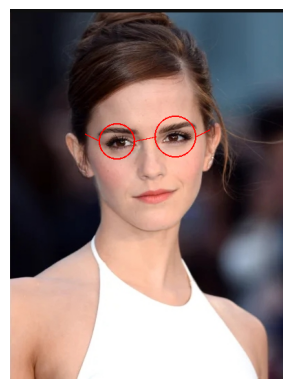

In [43]:
# Імпорт необхідних бібліотек
import cv2
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Завантаження даних з Excel-файлу
data_path = 'C:/Users/Xena/LabsPython/lab6.xlsx'
df = pd.read_excel(data_path)

# Отримання даних для конкретного варіанту (в даному випадку використовується перший рядок)
variant_data = df.iloc[0]
file_name = variant_data['file name']
image_size = tuple(map(int, variant_data['image size'].split('x')))
glasses_color = variant_data['glasses color']
line_width = int(variant_data['line width'])

# Функція для обробки зображення та додавання окулярів
def add_glasses(input_image_path, output_image_path, image_size, glasses_color, line_width):
    # Завантаження зображення
    image = cv2.imread(input_image_path)
    
    # Перевірка, чи зображення завантажено успішно
    if image is None:
        print(f"Помилка: Не вдалося завантажити зображення за шляхом {input_image_path}.")
        return None
    
    # Перетворення в градації сірого
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Завантаження каскадів Хаара для виявлення облич та очей
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
    
    # Виявлення облич
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    # Обробка кожного виявленого обличчя
    for (x, y, w, h) in faces:
        # Виявлення очей в межах верхньої частини обличчя
        face_region = gray[y:y + h//2, x:x + w]
        eyes = eye_cascade.detectMultiScale(face_region, scaleFactor=1.1, minNeighbors=10, minSize=(20, 20))
        
        # Перевірка кількості очей
        if len(eyes) >= 2:
            # Вибір двох найбільших очей
            eyes = sorted(eyes, key=lambda e: e[2] * e[3], reverse=True)[:2]
            
            # Визначення координат центрів очей
            eye_centers = []
            for (ex, ey, ew, eh) in eyes:
                eye_center = (x + ex + ew // 2, y + ey + eh // 2)
                eye_centers.append((eye_center, int(ew * 0.7)))  # Зберігаємо центр та радіус кожного ока

            # Сортування очей по горизонталі
            left_eye, right_eye = sorted(eye_centers, key=lambda e: e[0][0])

            # Малювання окулярів
            pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            draw = ImageDraw.Draw(pil_image)
            
            # Малювання кругів для окулярів
            for eye_center, radius in eye_centers:
                draw.ellipse(
                    (eye_center[0] - radius, eye_center[1] - radius,
                     eye_center[0] + radius, eye_center[1] + radius),
                    outline=glasses_color, width=line_width
                )
            
            # Додавання дуже короткої перемички між лінзами окулярів
            bridge_length = int(left_eye[1] * 0.1)  # Ще коротший розмір перемички
            draw.line(
                [(left_eye[0][0] + left_eye[1] - bridge_length, left_eye[0][1]),
                 (right_eye[0][0] - right_eye[1] + bridge_length, right_eye[0][1])],
                fill=glasses_color, width=line_width
            )

            # Додавання дужок окулярів
            for eye_center, radius in eye_centers:
                # Дужка буде відходити від зовнішнього краю окуляра
                side_x = eye_center[0] + (radius if eye_center == right_eye[0] else -radius)
                side_y = eye_center[1]
                draw.line(
                    [(side_x, side_y), (side_x + (20 if eye_center == right_eye[0] else -20), side_y - 10)],
                    fill=glasses_color, width=line_width
                )
            
            # Збереження та повернення зображення
            pil_image.save(output_image_path)
            print("Зображення збережено успішно.")
            return pil_image
        else:
            print("Ока не виявлено або знайдено менше двох очей.")
    
    print("Жодного зображення не було створено.")
    return None

# Шляхи до зображення
input_image_path = f'C:/Users/Xena/LabsPython/Images/{file_name}'  # Коректний шлях до зображення
output_image_path = 'C:/Users/Xena/LabsPython/Images/output_with_glasses.jpg'
output_image = add_glasses(input_image_path, output_image_path, image_size, glasses_color, line_width)

if output_image:
    plt.imshow(output_image)
    plt.axis('off')
    plt.show()
else:
    print("Зображення не створено.")

